# Part 6: Модель на базе Xception, уменьшаем аугментацию, увеличиваем размер картинки.
- Увеличим количество эпох.
- Добавим файн тюнинг.
- Увеличим размер картинки.
- Постепенно уменьшаем аугментацию.

## Библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf

config = tf.compat.v1.ConfigProto(
    gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.5))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *
from ImageDataAugmentor.image_data_augmentor import *
import albumentations

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.8.5 (tags/v3.8.5:580fbb0, Jul 20 2020, 15:57:54) [MSC v.1924 64 bit (AMD64)]
Numpy        : 1.19.4
Tensorflow   : 2.4.0
Keras        : 2.4.0


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
!pip freeze > requirements.txt

## Основные настройки

In [5]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

# EPOCHS = 15  # эпох на обучение
BATCH_SIZE = 16  # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR = 0.001 # lerning rate
VAL_SPLIT = 0.15  # сколько данных выделяем на тест = 15%

CLASS_NUM = 10  # количество классов в нашей задаче
IMG_SIZE1 = 480  # какого размера подаем изображения в сеть
IMG_SIZE2 = 640  # какого размера подаем изображения в сеть
IMG_CHANNELS = 3   # у RGB 3 канала
input_shape = (IMG_SIZE1, IMG_SIZE2, IMG_CHANNELS)

part = 'part_6'  # Версия эксперимента

In [6]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
PYTHONHASHSEED = 0

In [7]:
# Графики
def make_graf(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [8]:
# Тест модели
def start_learning(num_epochs):
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=test_generator,
        validation_steps=len(test_generator),
        epochs=num_epochs,
        callbacks=callbacks_list
    )

    return history

## EDA / Анализ данных

In [9]:
train_df = pd.read_csv("data/train.csv")
sample_submission = pd.read_csv("data/sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [11]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

Распределение классов достаточно равномерное — это хорошо.

In [12]:
# print('Распаковываем картинки')
# # Will unzip the files so that you can see them..
# for data_zip in ['train.zip', 'test.zip']:
#     with zipfile.ZipFile("data/"+data_zip, "r") as z:
#         z.extractall('data/')

# print(os.listdir('data/'))

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

Пример картинок (random sample)


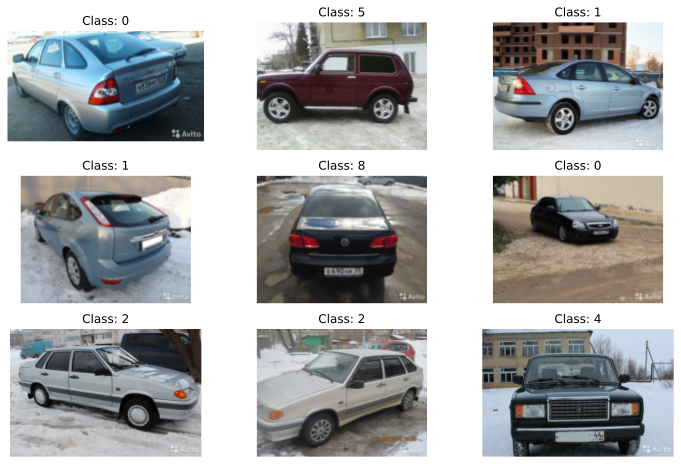

In [13]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12, 8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(f'data/train/{random_image_cat[index]}/{path}')
    plt.subplot(3, 3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')

plt.show()

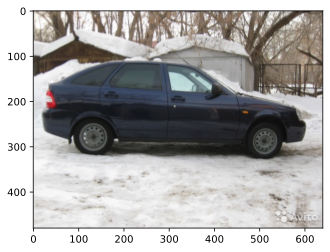

(640, 480)

In [14]:
image = PIL.Image.open('data/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

## Подготовка данных
### Аугментация данных

In [15]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=10, interpolation=1, border_mode=4,
                          value=None, mask_value=None, always_apply=False, p=0.8),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.2, contrast_limit=0.2),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.1, contrast_limit=0.1)
    ], p=0.7),
    albumentations.Blur(blur_limit=3, always_apply=False, p=0.5),
    albumentations.HueSaturationValue(
        hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, always_apply=False, p=0.7),
    albumentations.RGBShift(r_shift_limit=20, g_shift_limit=20,
                            b_shift_limit=20, always_apply=False, p=0.7),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.ChannelShuffle(p=0.7),
    albumentations.CLAHE(clip_limit=3.0, tile_grid_size=(
        8, 8), always_apply=False, p=0.3),
    albumentations.Resize(IMG_SIZE1, IMG_SIZE2)
])

train_datagen = ImageDataAugmentor(
    rescale=1./255,
    augment=AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

test_datagen = ImageDataAugmentor(rescale=1. / 255)

### Генерация данных

In [16]:
# Завернем наши данные в генератор:
train_generator = train_datagen.flow_from_directory(
    'data/train/',      # директория где расположены папки с картинками
    target_size=(IMG_SIZE1, IMG_SIZE2),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training')  # set as training data

test_generator = train_datagen.flow_from_directory(
    'data/train/',
    target_size=(IMG_SIZE1, IMG_SIZE2),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation')  # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory='data/test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE1, IMG_SIZE2),
    batch_size=BATCH_SIZE)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


Посмотрим результат

Пример картинок из train_generator


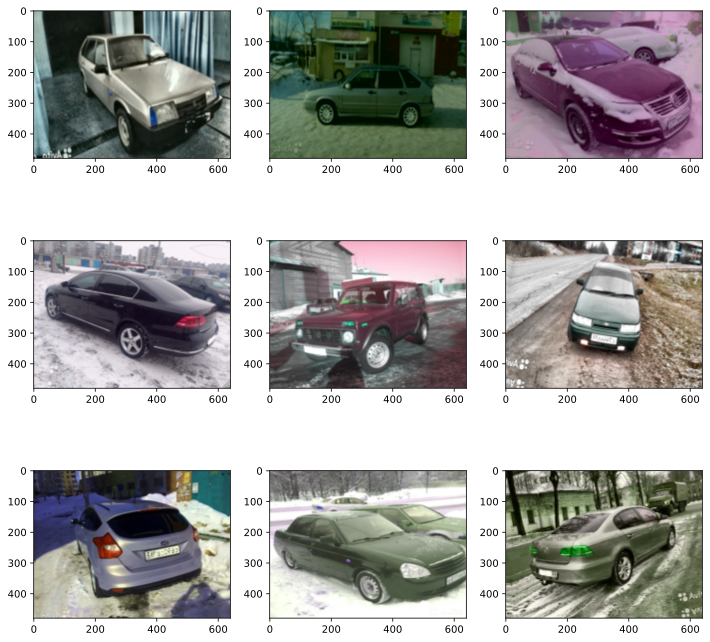

In [17]:
from skimage import io
 
def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()
 
x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,12))
 
for i in range(0,9):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

## Построение модели
### Загружаем предобученную сеть Xception

In [18]:
base_model = Xception(weights='imagenet',
                      include_top=False, input_shape=input_shape)

Замораживаем веса

In [19]:
# first: train only the top layers (which were randomly initialized)
base_model.trainable = False

Строим модель

In [20]:
# Устанавливаем новую "голову" (head)
x = base_model.output

x = BatchNormalization()(x)
# x = Dropout(0.2)(x)

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)

x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

## Обучение модели
Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [21]:
checkpoint = ModelCheckpoint('best_model_{}.hdf5'.format(
    part), monitor=['val_accuracy'], verbose=1, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

### Обучаем

In [22]:
history = start_learning(15)

Epoch 1/15
827/827 [==============================] - 1003s 1s/step - loss: 1.4326 - accuracy: 0.5315 - val_loss: 0.7614 - val_accuracy: 0.7274

Epoch 00001: saving model to best_model_part_6.hdf5
Epoch 2/15
827/827 [==============================] - 934s 1s/step - loss: 0.8328 - accuracy: 0.7010 - val_loss: 0.6640 - val_accuracy: 0.7647

Epoch 00002: saving model to best_model_part_6.hdf5
Epoch 3/15
827/827 [==============================] - 900s 1s/step - loss: 0.7116 - accuracy: 0.7497 - val_loss: 0.6179 - val_accuracy: 0.7888

Epoch 00003: saving model to best_model_part_6.hdf5
Epoch 4/15
827/827 [==============================] - 962s 1s/step - loss: 0.6401 - accuracy: 0.7721 - val_loss: 0.6204 - val_accuracy: 0.7802

Epoch 00004: saving model to best_model_part_6.hdf5
Epoch 5/15
827/827 [==============================] - 1095s 1s/step - loss: 0.6098 - accuracy: 0.7832 - val_loss: 0.5945 - val_accuracy: 0.7883

Epoch 00005: saving model to best_model_part_6.hdf5
Epoch 6/15
827/827

In [23]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('model_last_{}.h5'.format(part))
model.load_weights('best_model_{}.hdf5'.format(part))

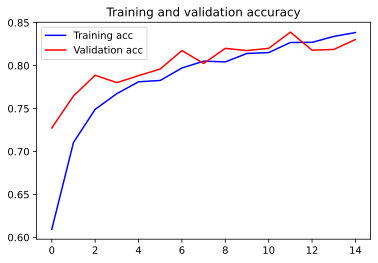

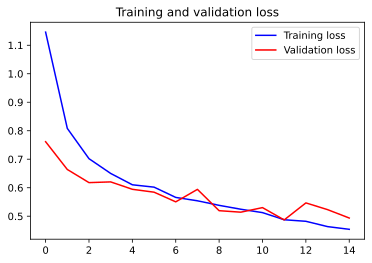

In [24]:
# Графики
make_graf(history)

Посмотрим сколько слоев в имиджнет модели

In [23]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  132


In [25]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 239, 319, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 239, 319, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 239, 319, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

Размораживаем имиджнет-модель частично (42 слоя размораживаем, 90 оставляем замороженными)

In [30]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 90

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Уменьшаем learning rate

In [31]:
LR=0.0005
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

Уменьшаем аугментацию

In [32]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=10, interpolation=1, border_mode=4,
                          value=None, mask_value=None, always_apply=False, p=0.7),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.2, contrast_limit=0.2),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.1, contrast_limit=0.1)
    ], p=0.6),
    albumentations.Blur(blur_limit=2, always_apply=False, p=0.4),
    albumentations.HueSaturationValue(
        hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, always_apply=False, p=0.5),
    albumentations.RGBShift(r_shift_limit=10, g_shift_limit=10,
                            b_shift_limit=10, always_apply=False, p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.3),
    albumentations.ChannelShuffle(p=0.5),
    albumentations.CLAHE(clip_limit=2.0, tile_grid_size=(
        8, 8), always_apply=False, p=0.2),
    albumentations.Resize(IMG_SIZE1, IMG_SIZE2)
])

train_datagen = ImageDataAugmentor(
    rescale=1./255,
    augment=AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

In [33]:
# Завернем наши данные в генератор:
train_generator = train_datagen.flow_from_directory(
    'data/train/',      # директория где расположены папки с картинками
    target_size=(IMG_SIZE1, IMG_SIZE2),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training')  # set as training data

test_generator = train_datagen.flow_from_directory(
    'data/train/',
    target_size=(IMG_SIZE1, IMG_SIZE2),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation')  # set as validation data

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.


Увеличиваем колиечество эпох обучения, т. к. уменьшили learnig rate

In [34]:
history = start_learning(20)

Epoch 1/20
827/827 [==============================] - 853s 1s/step - loss: 0.3699 - accuracy: 0.8698 - val_loss: 0.4275 - val_accuracy: 0.8690

Epoch 00001: saving model to best_model_part_6.hdf5
Epoch 2/20
827/827 [==============================] - 924s 1s/step - loss: 0.3222 - accuracy: 0.8873 - val_loss: 0.4145 - val_accuracy: 0.8579

Epoch 00002: saving model to best_model_part_6.hdf5
Epoch 3/20
827/827 [==============================] - 1048s 1s/step - loss: 0.3195 - accuracy: 0.8831 - val_loss: 0.4211 - val_accuracy: 0.8617

Epoch 00003: saving model to best_model_part_6.hdf5
Epoch 4/20
827/827 [==============================] - 907s 1s/step - loss: 0.3276 - accuracy: 0.8819 - val_loss: 0.3984 - val_accuracy: 0.8686

Epoch 00004: saving model to best_model_part_6.hdf5
Epoch 5/20
827/827 [==============================] - 913s 1s/step - loss: 0.3055 - accuracy: 0.8913 - val_loss: 0.4178 - val_accuracy: 0.8669

Epoch 00005: saving model to best_model_part_6.hdf5
Epoch 6/20
827/827 

In [35]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('model_last_{}.h5'.format(part))
model.load_weights('best_model_{}.hdf5'.format(part))

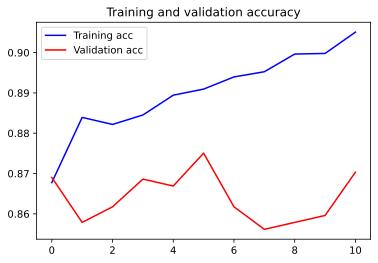

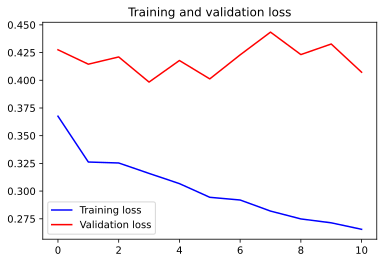

In [36]:
# Графики
make_graf(history)

Еще размораживаем имиджнет-модель частично (46 слоев оставляем замороженными)

In [27]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 46

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [28]:
LR=0.0001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

Уменьшаем аугментацию

In [29]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=10, interpolation=1, border_mode=4,
                          value=None, mask_value=None, always_apply=False, p=0.6),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.2, contrast_limit=0.2),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.1, contrast_limit=0.1)
    ], p=0.5),
    albumentations.Blur(blur_limit=1, always_apply=False, p=0.3),
    albumentations.HueSaturationValue(
        hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=5, always_apply=False, p=0.4),
    albumentations.RGBShift(r_shift_limit=5, g_shift_limit=5,
                            b_shift_limit=5, always_apply=False, p=0.4),
    # albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.3),
    # albumentations.ChannelShuffle(p=0.5),
    # albumentations.CLAHE(clip_limit=2.0, tile_grid_size=(
        # 8, 8), always_apply=False, p=0.2),
    albumentations.Resize(IMG_SIZE1, IMG_SIZE2)
])

train_datagen = ImageDataAugmentor(
    rescale=1./255,
    augment=AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

test_datagen = ImageDataAugmentor(rescale=1. / 255)

In [30]:
# Завернем наши данные в генератор:
train_generator = train_datagen.flow_from_directory(
    'data/train/',      # директория где расположены папки с картинками
    target_size=(IMG_SIZE1, IMG_SIZE2),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training')  # set as training data

test_generator = train_datagen.flow_from_directory(
    'data/train/',
    target_size=(IMG_SIZE1, IMG_SIZE2),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation')  # set as validation data

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.


Обучаем

In [31]:
history = start_learning(20)

Epoch 1/20
827/827 [==============================] - 825s 985ms/step - loss: 0.2331 - accuracy: 0.9177 - val_loss: 0.4037 - val_accuracy: 0.8720

Epoch 00001: saving model to best_model_part_6.hdf5
Epoch 2/20
827/827 [==============================] - 891s 1s/step - loss: 0.2059 - accuracy: 0.9242 - val_loss: 0.4012 - val_accuracy: 0.8793

Epoch 00002: saving model to best_model_part_6.hdf5
Epoch 3/20
827/827 [==============================] - 931s 1s/step - loss: 0.1998 - accuracy: 0.9272 - val_loss: 0.3771 - val_accuracy: 0.8772

Epoch 00003: saving model to best_model_part_6.hdf5
Epoch 4/20
827/827 [==============================] - 895s 1s/step - loss: 0.1980 - accuracy: 0.9269 - val_loss: 0.3948 - val_accuracy: 0.8772

Epoch 00004: saving model to best_model_part_6.hdf5
Epoch 5/20
827/827 [==============================] - 912s 1s/step - loss: 0.1859 - accuracy: 0.9320 - val_loss: 0.3810 - val_accuracy: 0.8824

Epoch 00005: saving model to best_model_part_6.hdf5
Epoch 6/20
827/82

In [33]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('model_last_{}.h5'.format(part))
model.load_weights('best_model_{}.hdf5'.format(part))

Окончательно размораживаем имиджнет-модель

In [23]:
base_model.trainable = True

Еще уменьшаем learning rate

In [24]:
LR=0.00005
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

Уменьшаем аугментацию

In [25]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=10, interpolation=1, border_mode=4,
                          value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.RandomBrightnessContrast(
        brightness_limit=0.1, contrast_limit=0.1, p=0.4),
    # albumentations.Blur(blur_limit=1, always_apply=False, p=0.2),
    # albumentations.HueSaturationValue(
    #     hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=5, always_apply=False, p=0.4),
    # albumentations.RGBShift(r_shift_limit=5, g_shift_limit=5,
    #                         b_shift_limit=5, always_apply=False, p=0.4),
    # albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.3),
    # albumentations.ChannelShuffle(p=0.5),
    # albumentations.CLAHE(clip_limit=2.0, tile_grid_size=(
        # 8, 8), always_apply = False, p = 0.2),
    albumentations.Resize(IMG_SIZE1, IMG_SIZE2)
])

train_datagen=ImageDataAugmentor(
    rescale= 1./255,
    augment= AUGMENTATIONS,
    validation_split= VAL_SPLIT,
)

test_datagen=ImageDataAugmentor(rescale = 1. / 255)

In [26]:
# Завернем наши данные в генератор:
train_generator = train_datagen.flow_from_directory(
    'data/train/',      # директория где расположены папки с картинками
    target_size=(IMG_SIZE1, IMG_SIZE2),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training')  # set as training data

test_generator = train_datagen.flow_from_directory(
    'data/train/',
    target_size=(IMG_SIZE1, IMG_SIZE2),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation')  # set as validation data

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.


Обучаем

In [27]:
history = start_learning(20)

Epoch 1/20
827/827 [==============================] - 834s 1s/step - loss: 0.1377 - accuracy: 0.9511 - val_loss: 0.3971 - val_accuracy: 0.8806

Epoch 00001: saving model to best_model_part_6.hdf5
Epoch 2/20
827/827 [==============================] - 875s 1s/step - loss: 0.1353 - accuracy: 0.9532 - val_loss: 0.3679 - val_accuracy: 0.8858

Epoch 00002: saving model to best_model_part_6.hdf5
Epoch 3/20
827/827 [==============================] - 858s 1s/step - loss: 0.1395 - accuracy: 0.9529 - val_loss: 0.3748 - val_accuracy: 0.8836

Epoch 00003: saving model to best_model_part_6.hdf5
Epoch 4/20
827/827 [==============================] - 816s 987ms/step - loss: 0.1328 - accuracy: 0.9526 - val_loss: 0.3773 - val_accuracy: 0.8836

Epoch 00004: saving model to best_model_part_6.hdf5
Epoch 5/20
827/827 [==============================] - 794s 960ms/step - loss: 0.1341 - accuracy: 0.9529 - val_loss: 0.3864 - val_accuracy: 0.8845

Epoch 00005: saving model to best_model_part_6.hdf5
Epoch 6/20
827

In [28]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('model_last_{}.h5'.format(part))
model.load_weights('best_model_{}.hdf5'.format(part))

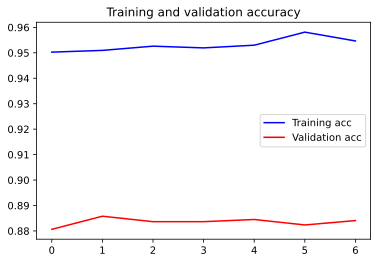

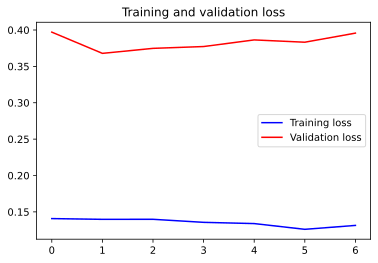

In [29]:
# Графики
make_graf(history)

### Оценим метрику

In [23]:
scores = model.evaluate_generator(
    test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

146/146 [==============================] - 141s 943ms/step - loss: 0.4923 - accuracy: 0.8570
Accuracy: 85.70%


## Предсказание на тестовых данных

In [24]:
test_sub_generator.samples

6675

In [25]:
test_sub_generator.reset()
predictions = model.predict_generator(
    test_sub_generator, steps=len(test_sub_generator), verbose=1)
predictions = np.argmax(predictions, axis=-1)  # multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v, k) for k, v in label_map.items())  # flip k,v
predictions = [label_map[k] for k in predictions]

418/418 [==============================] - 382s 914ms/step


In [26]:
filenames_with_dir = test_sub_generator.filenames
submission = pd.DataFrame(
    {'Id': filenames_with_dir, 'Category': predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/', '')
submission.to_csv('submission_{}.csv'.format(part), index=False)
print('Save submit')

Save submit


In [27]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,8
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,9


### Вывод по данной части работы:
- Метрика на тесте: 85.70%
- Метрика на Kaggle: 88.269%

**Предварительные выводы:**
- В данном эксперименте получился не лучший результат, но приобретен бессценный опыт.